Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

# Aprendizado profundo com Python

## 7.2 Inspecionar e monitorar modelos de aprendizado profundo usando callbacks Keras e TensorBoard

> Use funções de retorno de chamada Keras e TensorBoard para inspecionar e monitorar modelos de aprendizado profundo

Depois de iniciar uma tarefa de treinamento complexa com model.fit (), só podemos esperar. Não sabemos se ele está funcionando corretamente ou não podemos controlá-lo antes do final. É como jogar um avião de papel e deixá-lo ir O vento vai para uma distância incerta. Em vez de um avião de papel descontrolado, talvez preferíssemos um drone inteligente que possa detectar o ambiente, enviar dados para nós e navegar de forma autônoma com base no estado atual. A função de retorno de chamada de Keras e ferramentas como TensorBoard podem nos ajudar a transformar "aviões de papel" em "drones inteligentes".

### Aplicar a função de retorno de chamada ao modelo durante o treinamento

Quando treinamos o modelo, não sabemos quantas rodadas executar no início, só podemos deixá-lo executar rodadas suficientes e, em seguida, encontrar manualmente um número ideal de rodadas e reutilizar esse número ideal de rodadas para treinar Modelo, isso consome muito tempo. Portanto, preferimos parar automaticamente o treinamento quando o modelo observa que a perda de verificação não está mais melhorando.

Este tipo de operação pode ser feito com a função de retorno de chamada do Keras (retorno de chamada): Keras fornece muitos retornos de chamada úteis, que são colocados em `keras.callbacks`. Parar automaticamente o treinamento é apenas um dos usos.

O retorno de chamada será chamado pelo modelo em diferentes pontos do processo de treinamento. Ele pode acessar o estado do modelo e realizar algumas ações, como:

- Ponto de verificação do modelo: salvar o peso atual do modelo em diferentes pontos do processo de treinamento
- Término precoce: interromper o treinamento quando a perda de verificação não melhorar mais
- Ajuste dinamicamente os valores dos parâmetros: por exemplo, ajuste dinamicamente a taxa de aprendizagem do otimizador
- Registre indicadores de treinamento e indicadores de verificação: Use esses indicadores para visualizar a representação aprendida pelo modelo
-...

#### Use callback

Keras tem muitos retornos de chamada úteis integrados, como:

-`ModelCheckpoint`: Salva o modelo treinado para determinados estados durante o processo de treinamento. Ele pode ser usado para salvar o modelo continuamente ou para salvar o melhor modelo atualmente;
-`EarlyStopping`: o indicador de meta monitorado, se não melhorar dentro do número de rodadas definido, o treinamento será interrompido;
-`ReduceLROnPlateau`: Reduz a taxa de aprendizagem quando a perda de verificação não melhora mais (quando encontra um platô de perda).

O uso desses callbacks também é muito simples:

`` `python
de tensorflow import keras

callbacks_list = [
    # Economize o peso após cada rodada
    keras.callbacks.ModelCheckpoint (
        filepath = 'my_model.h5', # caminho para salvar o arquivo
        monitor = 'val_loss', # monitor: o indicador a ser verificado
        save_best_only = True, # Salve apenas o modelo que torna o indicador do monitor o melhor (se o monitor não melhorar, ele não será salvo)
    ),
    # Interromper o treinamento quando não estiver mais melhorando
    keras.callbacks.EarlyStopping (
        monitor = 'acc', # o indicador a ser verificado
        paciência = 10, # Se o monitor não melhorar em mais de rodadas de paciência (por exemplo, 10 + 1 = 11 rodadas aqui), pare o treinamento
    ),
    # Reduza a taxa de aprendizagem quando não estiver mais melhorando
    keras.callbacks.ReduceLROnPlateau (
        monitor = 'val_loss', # indicador a ser verificado
        fator = 0,1, # Quando acionado: taxa de aprendizagem * = fator
        paciência = 5, # monitor não melhora na rodada de paciência, aciona para reduzir a taxa de aprendizagem
    ),
]

model.compile (optimizer = 'rmsprop',
              perda = 'binary_crossentropy',
              metrics = ['acc']) # acc é usado como um indicador no retorno de chamada, então deve haver métricas de conta aqui

model.fit (x, y,
          épocas = 10,
          batch_size = 32,
          callbacks = callbacks_list, # Use esses callbacks durante o treinamento
          validation_data = (x_val, y_val)) # val é usado no retorno de chamada, então deve haver val aqui
`` `

#### Escreva sua própria função de retorno de chamada

Além de usar retornos de chamada integrados do Keras, você também pode escrever retornos de chamada para concluir as operações que não são internas.

Escreva callbacks criando subclasses de `keras.callbacks.Callback`. Semelhante a escrever scripts de jogos, implemente alguns métodos nesta subclasse e, em seguida, esses métodos serão chamados em pontos específicos do processo de treinamento:

| Método | Tempo chamado |
| -------------- | -------------------- |
| on_epoch_begin | Chamado no início de cada rodada |
| on_epoch_end | Chamado ao final de cada rodada |
| |
| on_batch_begin | Chamado antes de cada lote ser processado |
| on_batch_end | Chamado após o processamento de cada lote |
| |
| on_train_begin | Chamado no início do treinamento |
| on_train_end | Chamado no final do treinamento |

Esses métodos aceitam um parâmetro de logs (tipo dict), que contém informações sobre a época ou lote ou trem anterior, incluindo indicadores de treinamento, indicadores de verificação e semelhantes.

Entre esses métodos, você também pode acessar:

-`self.model`: a instância do modelo que chama o callback;
-`self.validation_data`: ajustar os dados de validação passados;

Por exemplo, escrevemos uma função de retorno de chamada personalizada para salvar o valor de cálculo de ativação de cada camada do modelo para a primeira amostra do conjunto de validação após cada rodada:

In [3]:
Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. from tensorflow import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):  # Chamado pelo modelo pai antes do treinamento, diga à função de retorno de chamada qual modelo está chamando
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input, layer_outputs)  # Instância de modelo, retorno de ativação de cada camada
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        with open(f'activations_at_epoch_{epoch}.npz', 'w') as f:
            np.savez(f, activations)

### Introdução ao TensorBoard: estrutura de visualização do TensorFlow

Para fazer um modelo melhor, além de pensar na arquitetura e escrever código, também precisamos obter informações sobre o modelo, entender o que está acontecendo dentro do modelo durante o processo de treinamento e usar essas informações para saber se podemos pensar e otimizar o modelo.

O pensamento é feito em sua mente. O código para escrever o modelo pode ser facilmente implementado usando a API Keras, e a compreensão do modelo pode ser emprestada do TensorBoard. O TensorBoard é uma ferramenta de visualização baseada em navegador integrada ao TensorFlow. Ele permite monitorar visualmente tudo o que acontece dentro do modelo durante o processo de treinamento.

! [Ciclo de progresso] (https://tva1.sinaimg.cn/large/007S8ZIlgy1ghp9tjfuzcj312g0d6acp.jpg)

O TensorBoard tem principalmente as seguintes funções:

- Monitore os indicadores visualmente durante o treinamento
-Visualizar a arquitetura do modelo
-Visualizar histogramas de ativação e gradiente
- Estudo de incorporação em três dimensões

Treinamos uma rede neural convolucional unidimensional na tarefa de análise de sentimento IMDB para demonstrar o uso do TensorBoard:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

Para usar o TensorBoard, alguns preparativos são necessários antes de iniciar o treinamento. Primeiro, crie um diretório para os arquivos de log exigidos pelo TensorBoard e inicie o serviço do TensorBoard. Na casca:

`` `shell
$ mkdir my_log_dir
`` `

Ou, no Jupyter Notebook:

In [21]:
%mkdir my_log_dir

Em seguida, instancie uma função de retorno de chamada do TensorBoard:

In [22]:
import tensorflow as tf

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='my_log_dir',  # Local de armazenamento de arquivos de log
    histogram_freq=1,      # Registre o histograma de ativação após cada rodada histogram_freq
    embeddings_freq=1,     # Grave embeddings de palavras após cada rodada histogram_freq
)

Por fim, use este retorno de chamada durante o treinamento:

In [23]:
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=[tensorboard_callback])

Epoch 1/20
157/157 [==============================] - 25s 156ms/step - loss: 0.6376 - acc: 0.6424 - val_loss: 0.7053 - val_acc: 0.7210
Epoch 2/20
157/157 [==============================] - 24s 152ms/step - loss: 0.4426 - acc: 0.8489 - val_loss: 0.5328 - val_acc: 0.8378
Epoch 3/20
157/157 [==============================] - 25s 161ms/step - loss: 0.3988 - acc: 0.8807 - val_loss: 0.4488 - val_acc: 0.8688
Epoch 4/20
157/157 [==============================] - 24s 155ms/step - loss: 0.3680 - acc: 0.8965 - val_loss: 0.5022 - val_acc: 0.8714
Epoch 5/20
157/157 [==============================] - 25s 162ms/step - loss: 0.3123 - acc: 0.9168 - val_loss: 0.4771 - val_acc: 0.8688
Epoch 6/20
157/157 [==============================] - 25s 162ms/step - loss: 0.2550 - acc: 0.9387 - val_loss: 0.7022 - val_acc: 0.8640
Epoch 7/20
157/157 [==============================] - 24s 156ms/step - loss: 0.2419 - acc: 0.9470 - val_loss: 0.7245 - val_acc: 0.8758
Epoch 8/20
157/157 [==============================] - 2

Depois de iniciar o treinamento, você pode iniciar o serviço TensorBoard:

`` `shell
$ tensorboard --logdir = my_log_dir
`` `

Ou no Jupyter Notebook:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=my_log_dir

Agora você pode abrir `http: // localhost: 6006` no navegador para visualizar o processo de treinamento do modelo de visualização do TensorBoard.

-Na guia Escalares, você pode ver a curva de mudança de precisão e perda durante o processo de treinamento. O conteúdo é o mesmo que desenhamos com plt após cada treinamento, mas no TensorBoard você pode atualizar para vê-lo a qualquer momento sem esperar pelo treinamento executar;
-Na guia Gráfico, a visualização do gráfico de operação do TensorFlow subjacente por trás do modelo Keras é exibida. Este gráfico de operação subjacente é mais complexo do que nosso modelo Keras. Este é o trabalho que Keras simplificou para nós. Keras nos permite não mexer nessas coisas complicadas. , Para tornar o fluxo de trabalho muito simples; se quiser ver a representação gráfica do próprio modelo Keras, você pode usar `keras.utils.plot_model`:

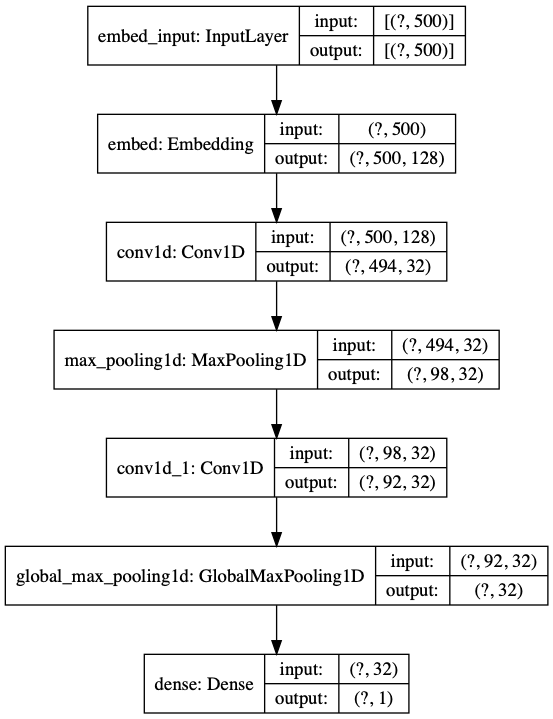

In [3]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
# show_shapes = True pode exibir as formas de tensor de entrada e saída de cada camada

-Na página da guia Histogramas, há um histograma de valores de ativação para cada camada;
-Na página da guia Projetor, há uma relação espacial de embeddings de palavras de 2.000 palavras em nosso vocabulário. Esta é uma imagem de "projeção" obtida reduzindo o espaço de incorporação de 128 dimensões aprendido pela camada de incorporação para 2 ou 3 dimensões usando algoritmos como PCA. Se estiver interessado no significado de cada ponto, você pode clicar em um ponto para ver seu número e, em seguida, usar o seguinte código para restaurar a palavra para ver:

In [40]:
index_word = {v: k for k, v in imdb.get_word_index().items()}
def show_word_of_index(idx):  # idx digite o número da palavra que você vê
    print(index_word[idx])

show_word_of_index(123)

ever
